# Trabajo Integrador Procesamiento de Imagenes
En esta actividad, vamos a poner en práctica todo lo que aprendimos sobre procesamiento de imágenes para crear un proyecto.

Objetivo: El objetivo de este proyecto es utilizar procedimientos básicos de procesamiento de imágenes con la finalidad de:
* Leer una imagen
* Aplicarle mejoras de brillo y contraste (Ecualizacion Histograma)
* Rotacion de imagen
* Segmentar objetos de interes (ROI)
* Aplicaciones de mascara de mejoras a ROI
* Mostrar los resultados en una presentación visual.

Entorno: Google Colab

Imagen: Imagen propia sacada en un acuario en San Juan, un pez de la especie Pseudocrenilabrus macho.

## 1 - Importar Librerias Necesarias
Lo primero que vamos a hacer es importar las herramientas que vamos a utilizar.

In [101]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from skimage import color, feature, measure, filters, morphology, segmentation
from skimage.morphology import disk, closing, opening, erosion, dilation

## 2 - Funciones Auxiliares
Funciones utiles que iremos reutilizando a lo largo del laboratorio

In [102]:
# Muestra informacion de la imagen
def mostrar_imagen_info(imagen, titulo="\nInformacion de la Imagen"):
    print(f"{titulo.upper()}:\n")
    print(f"   Dimensiones: {imagen.shape}")                                 # Dimensiones (altura, ancho, canales)
    print(f"   Tipo de datos: {imagen.dtype}")                               # Tipo de datos (float64, uint8, etc.)
    print(f"   Rango de valores: [{imagen.min():.3f}, {imagen.max():.3f}]")  # Min y max
    print(f"   Valor promedio de todos los píxeles: {imagen.mean():.3f}")    # Media de todos los píxeles
    print(f"   Desviación estándar: {imagen.std():.3f}")                     # Variabilidad de los valores

# Funcion que muestra la imagen antes y despues del procesamiento
def mostrar_imagen(imagen_antes, imagen_despues, titulo_proceso):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Define fig and axes here
  fig.suptitle(titulo_proceso, fontsize=16)

  axes[0].imshow(imagen_antes)
  axes[0].set_title('Imagen Antes')
  axes[0].axis('off')

  axes[1].imshow(imagen_despues)
  axes[1].set_title('Imagen Despues')
  axes[1].axis('off')

  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()

## 3 - Primer vistazo de la Imagen
Subir la imagen: Si van a usar una foto propia, súbanla a Google Colab. Para hacerlo, hagan clic en el ícono de la carpeta en la barra lateral izquierda, luego en el ícono de "Subir" y seleccionen su archivo.

Leer la imagen: Con cv2.imread(), vamos a leer la imagen. Como OpenCV lee las imágenes en formato BGR, tenemos que convertir la imagen a RGB para poder verla bien con Matplotlib.


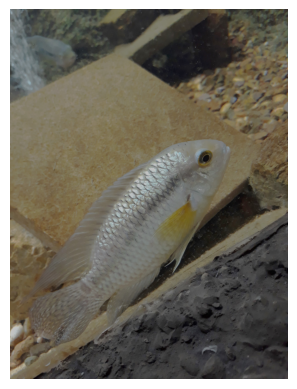


INFORMACION DE LA IMAGEN:

   Dimensiones: (4128, 3096, 3)
   Tipo de datos: uint8
   Rango de valores: [0.000, 212.000]
   Valor promedio de todos los píxeles: 87.886
   Desviación estándar: 33.186


In [103]:
imagen = cv2.imread('/content/imagen.jpg')
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.imshow(imagen)
plt.axis('off')
plt.show()

mostrar_imagen_info(imagen)


## 4 - Mejora de brillo y contraste con Ecualización de histograma
Creamos una función para modificar estos aspectos de la imagen.
* Ecualización de histograma: Con cv2.equalizeHist(), vamos a mejorar el contraste de la imagen.

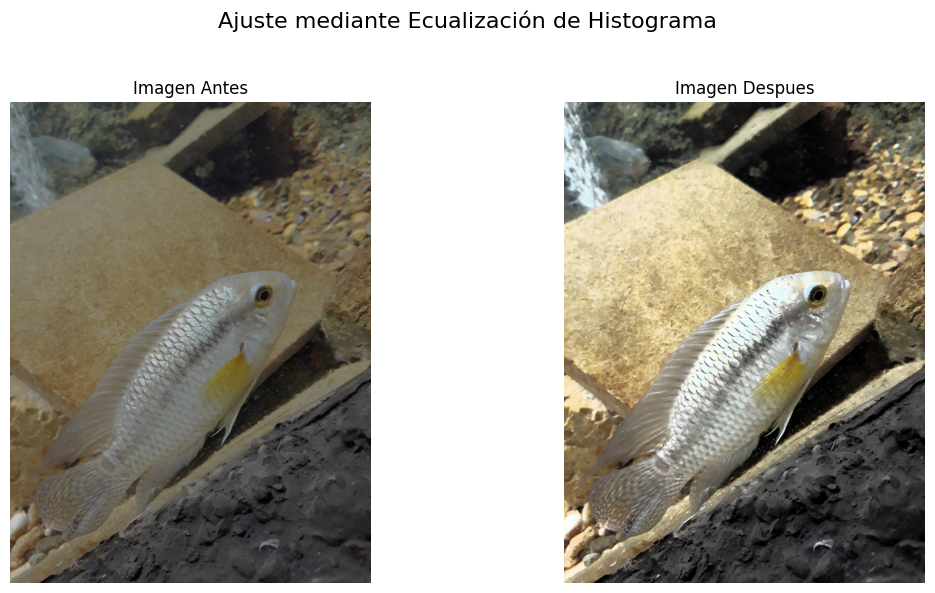

In [104]:
# Función para modificar brillo y contraste
def ecualizar_histograma(imagen):
    ecualize_hist = cv2.cvtColor(imagen, cv2.COLOR_RGB2HSV)
    ecualize_hist[:, :, 2] = cv2.equalizeHist(ecualize_hist[:, :, 2])
    imagen_ecualize_hist = cv2.cvtColor(ecualize_hist, cv2.COLOR_HSV2RGB)
    return imagen_ecualize_hist

imagen_2 = imagen.copy()
imagen_ecualize_hist = ecualizar_histograma(imagen_2)

titulo_proceso = "Ajuste mediante Ecualización de Histograma"
mostrar_imagen(imagen, imagen_ecualize_hist, titulo_proceso)

## 5 - Rotamos la Imagen
El objetivo de esta tares es corregir la inclinación del pez para obtener una vista recta y horizontal del objeto, lo que facilita el análisis de la forma, la medición de sus características, o su posterior clasificación.

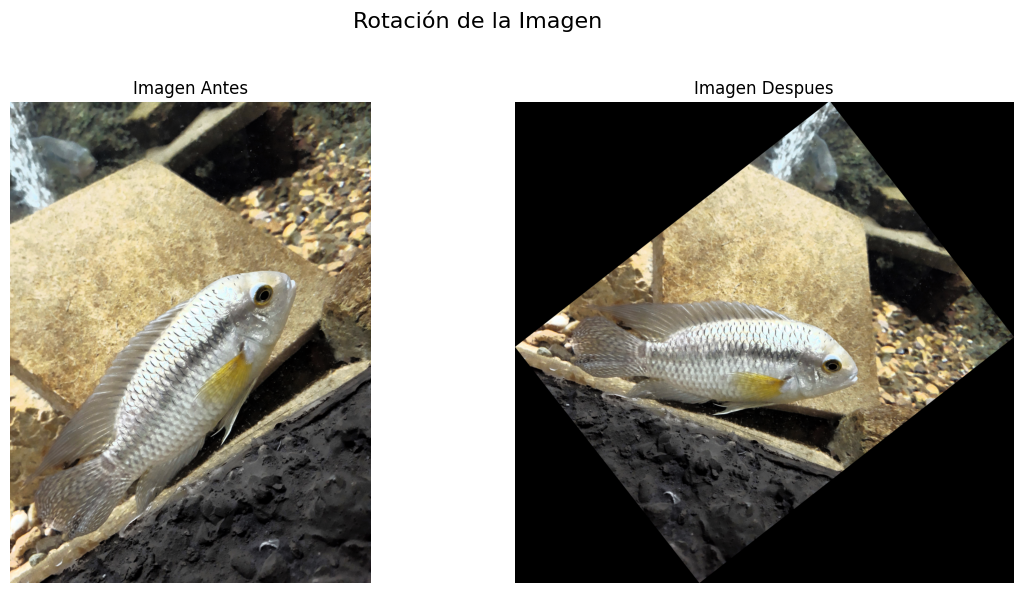

In [105]:
imagen_3 = imagen_ecualize_hist.copy()

# Definimos el centro e la imagen y la inclinacion del pez
centro = (imagen_3.shape[1] // 2, imagen_3.shape[0] // 2)
angulo = -52

# Calcula las nuevas dimensiones, para evitar el recorte
altura, ancho = imagen_3.shape[:2]

# Convierte angulos en radianes
rad = np.deg2rad(angulo)

# Calcula nuevas dimensiones
nuevo_ancho = int((ancho * abs(np.cos(rad))) + (altura * abs(np.sin(rad))))
nueva_altura = int((ancho * abs(np.sin(rad))) + (altura * abs(np.cos(rad))))

# Ajusta la matriz de rotacion
M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
M[0, 2] += (nuevo_ancho / 2) - centro[0]
M[1, 2] += (nueva_altura / 2) - centro[1]

# Aplica la rotacion con la nueva dimension
roi_rotado = cv2.warpAffine(imagen_3, M, (nuevo_ancho, nueva_altura))

titulo_proceso = "Rotación de la Imagen"
mostrar_imagen(imagen_ecualize_hist, roi_rotado, titulo_proceso)

## 6 - Segmentacion de la Imagen por color
La técnica de umbralización y segmentación fue la más efectiva para aislar el objeto principal del fondo complejo y lleno de elementos distractores. Al aplicar un umbral adecuado, se logra separar la figura objetivo del fondo, permitiendo obtener una máscara binaria del objeto de interés.

### 6.1 - Segmentacion Automática con K-means clustering

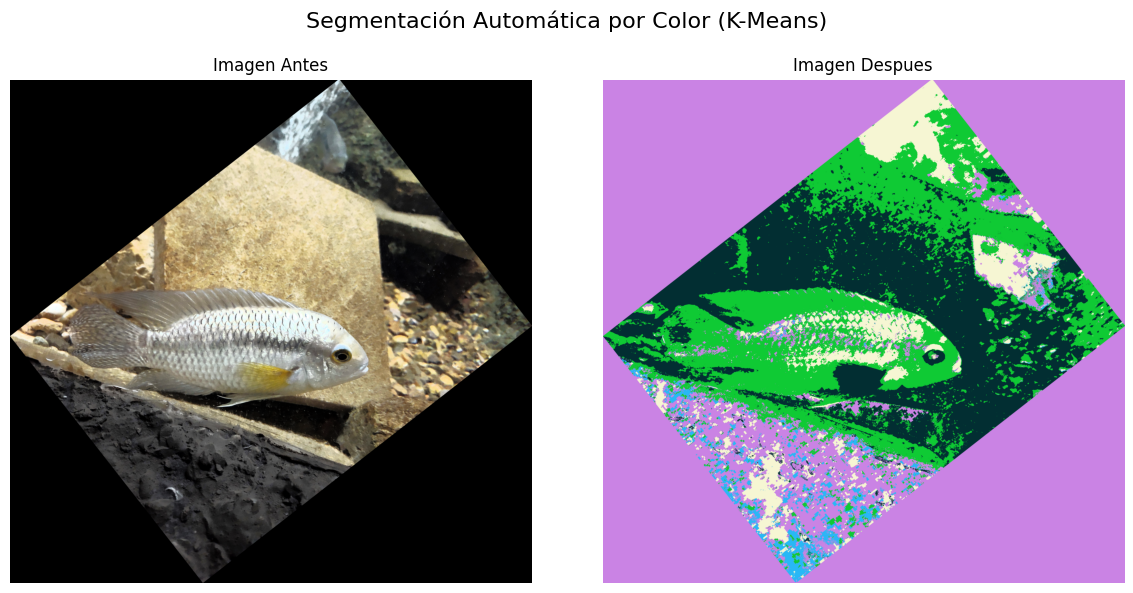

In [142]:
imagen_to_segment = roi_rotado.copy() # Use the rotated image on the canvas

def segmentar_por_color_hsv_auto(imagen, num_colores=5):
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_RGB2HSV)

    # Obtener dimensiones para reshape posterior
    altura, ancho, _ = imagen_hsv.shape
    pixeles_hs = imagen_hsv[:,:,:2].astype(np.float32) # Use float32 for normalization
    pixeles_hs[:,:,1] = (pixeles_hs[:,:,1] / 255.0) * 179.0 # Normalize S

    # Reshape a (n_pixeles, 2)
    pixeles_hs_reshaped = pixeles_hs.reshape(-1, 2)

    # Aplicar K-means clustering
    # random_state=42 garantiza resultados reproducibles
    # n_init='auto' es el default en versiones recientes de sklearn.
    kmeans = KMeans(n_clusters=num_colores, random_state=42, n_init='auto')
    etiquetas = kmeans.fit_predict(pixeles_hs_reshaped)

    # Reformar etiquetas de vuelta a forma de imagen
    segmentacion = etiquetas.reshape(altura, ancho)

    # Crear una imagen a color a partir de la segmentación
    # Asignar un color diferente a cada etiqueta de cluster
    colores = np.random.randint(0, 256, size=(num_colores, 3), dtype=np.uint8)
    imagen_segmentada_color = np.zeros((altura, ancho, 3), dtype=np.uint8)

    for i in range(num_colores):
        imagen_segmentada_color[segmentacion == i] = colores[i]

    return segmentacion, kmeans, imagen_segmentada_color

# Aplicamos la mascara a la imagen rotada
segmentacion_mask, modelo_kmeans, imagen_segmentada_color_viz = segmentar_por_color_hsv_auto(imagen_to_segment)

# Mostramos el antes y despues del procesamiento
titulo_proceso = "Segmentación Automática por Color (K-Means)"
mostrar_imagen(imagen_to_segment, imagen_segmentada_color_viz, titulo_proceso)



### 6.2 - Segmentacion por color con  limites definidos
Elegimos el rango de colores blanco y gris en el que se encuentra el pez para realizar la segmentacion

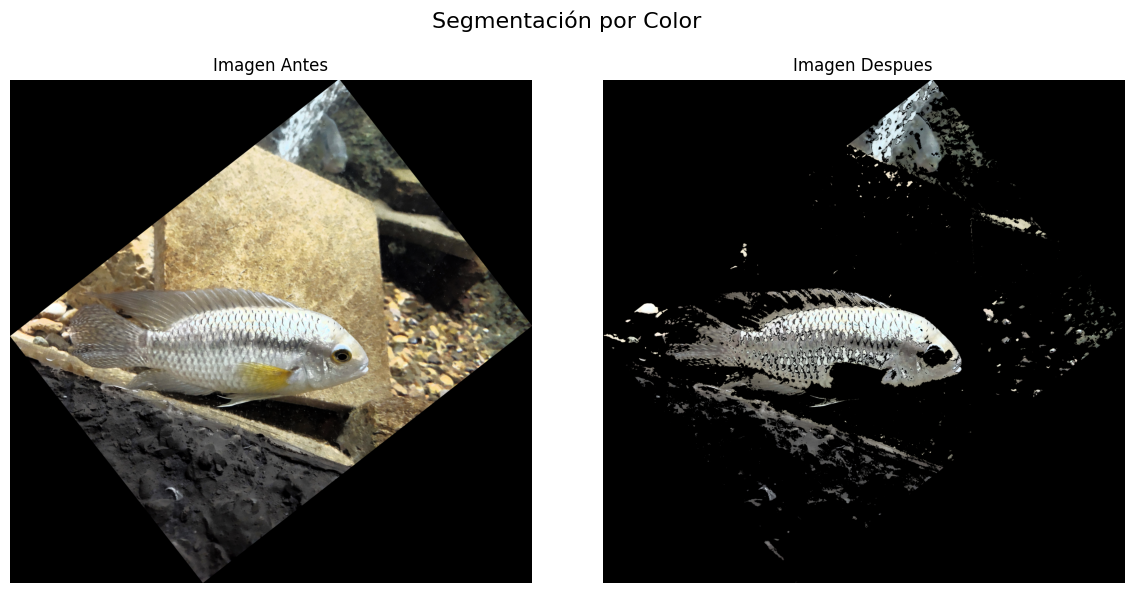

In [107]:
imagen_4 = roi_rotado.copy()

# RANGO 1: Blanco
blanco_bajo = np.array([0, 0, 200])     # H cualquiera (0), S mínima, V alto
blanco_alto = np.array([179, 40, 255])  # S bajo (0–40), V muy alto (200–255)

# RANGO 2: Gris
gris_bajo = np.array([0, 0, 80])      # H cualquiera, S casi 0, V bajo
gris_alto = np.array([179, 40, 180])  # S bajo (0–50), V medio (60–140)

# Convertir imagen a HSV
imagen_hsv = cv2.cvtColor(imagen_4, cv2.COLOR_BGR2HSV)

# Blanco
mask_blanco = cv2.inRange(imagen_hsv, blanco_bajo, blanco_alto)

# Gris
mask_gris = cv2.inRange(imagen_hsv, gris_bajo, gris_alto)

# Combinar si quieres detectar ambos
mask_total = cv2.bitwise_or(mask_blanco, mask_gris)

# Aplicar la máscara a la imagen original
imagen_segmentada = cv2.bitwise_and(imagen_4, imagen_4, mask=mask_total)

# Mostrar antes y despues
titulo_proceso = "Segmentación por Color"
mostrar_imagen(imagen_4, imagen_segmentada, titulo_proceso)




## 7 - Aplicacion de mascara de binaria
Creamos una funcion que limpia máscaras binarias usando operaciones morfológicas. De esta manera se elimina ruido y conecta regiones fragmentadas.

Operaciones de la funcion:
Operaciones disponibles:
* 'close': Cierra huecos pequeños (dilatación + erosión)
* 'open': Elimina ruido pequeño (erosión + dilatación)
* 'erode': Reduce el tamaño de las regiones
* 'dilate': Expande las regiones

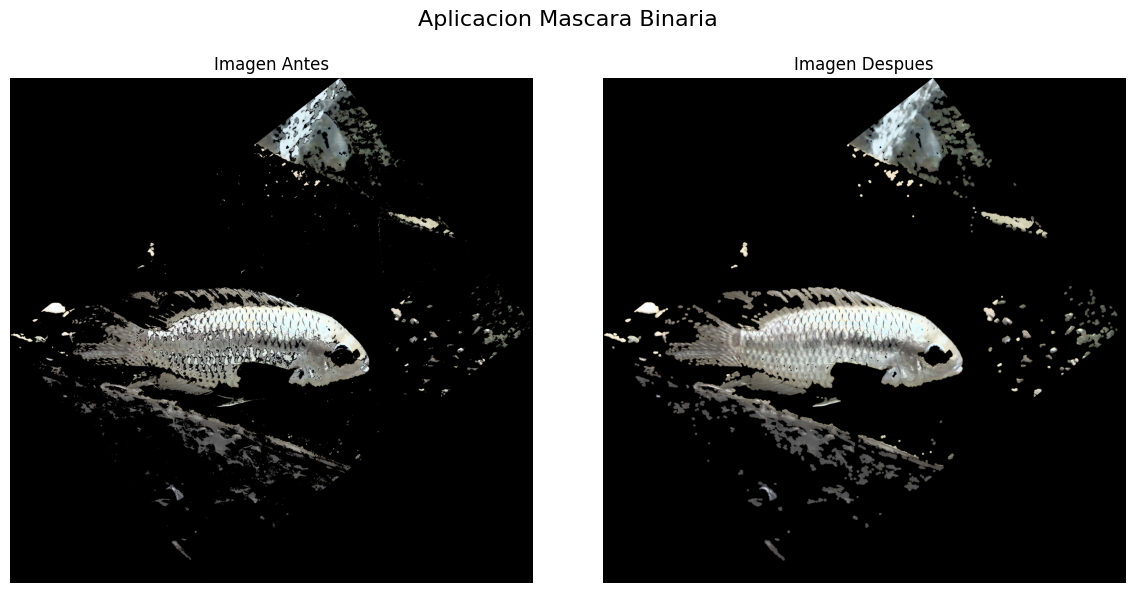

In [108]:
def limpiar_mascara_morfologia(mascara, tam_kernel=5, operaciones=['close', 'open', 'dilate']):
    # Crear elemento estructurante circular
    # disk() crea un círculo que preserva mejor las formas naturales
    kernel = disk(tam_kernel)
    resultado = mascara.copy()

    # Aplicar operaciones en el orden especificado
    for op in operaciones:
        if op == 'close':
            # Closing: Conecta regiones cercanas y cierra huecos
            resultado = closing(resultado, kernel)
        elif op == 'open':
            # Opening: Elimina regiones pequeñas (ruido)
            resultado = opening(resultado, kernel)
        elif op == 'erode':
            # Erosión: Reduce tamaño de regiones (adelgaza bordes)
            resultado = erosion(resultado, kernel)
        elif op == 'dilate':
            # Dilatación: Expande regiones (engrosa bordes)
            resultado = dilation(resultado, kernel)

    return resultado
mascara_limpia = limpiar_mascara_morfologia(mask_total)
# Aplicar la máscara a la imagen original
imagen_limpia = cv2.bitwise_and(imagen_4, imagen_4, mask=mascara_limpia)

# Mostrar antes y despues
titulo_proceso = "Aplicacion Mascara Binaria"
mostrar_imagen(imagen_segmentada, imagen_limpia, titulo_proceso)



## 8 - Dibujamos y escribimos sobre la imagen
Para terminar, vamos a agregarle un poco de información a nuestra imagen segmentada.



### 8.1 - Deteccion de objetos automatico con cv2.findContours()
Definiendo un area minima en pixeles se detectan objetos de manera automatica

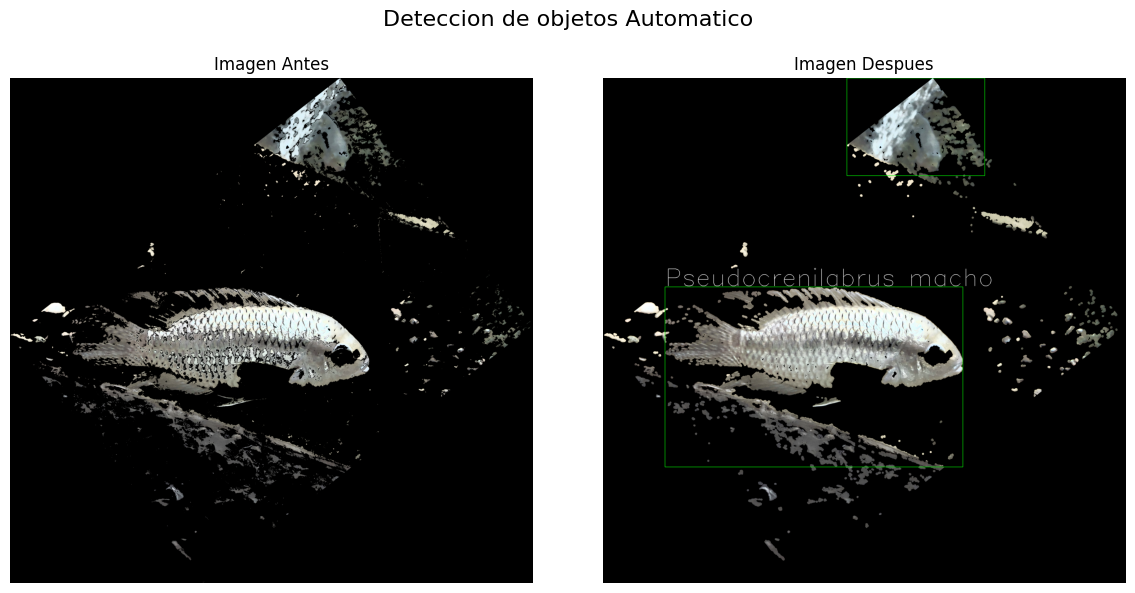

In [109]:
imagen_5 = imagen_limpia.copy()

# Convertir a escala de grises y encontrar contornos
imagen_gris = cv2.cvtColor(imagen_5, cv2.COLOR_BGR2GRAY)
contornos, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Definir un umbral de área mínima (ajústalo según tu imagen)
area_minima = 100000  # píxeles

for contorno in contornos:
    area = cv2.contourArea(contorno)

    if area >= area_minima:  # Filtrar solo los contornos grandes
        x, y, w, h = cv2.boundingRect(contorno)
        cv2.rectangle(imagen_5, (x, y), (x + w, y + h), (0, 255, 0), 3)

        texto = "Pseudocrenilabrus macho"
        posicion_texto = (x, y - 10)
        cv2.putText(imagen_5, texto, posicion_texto,
                    cv2.FONT_HERSHEY_SIMPLEX, 8, (255, 255, 255), 3)

# Mostrar resultado
titulo_proceso = "Deteccion de objetos Automatico"
mostrar_imagen(imagen_segmentada, imagen_5, titulo_proceso)

### 8.2 - Dibujar figuras y texto sobre la imagen
* Dibujar lineas: Usando cv2.line()
* Dibujar rectangulos: Usando cv2.rectangle()
* Insertar texto: Usando cv2.putText()

In [118]:
imagen_6 = imagen_limpia.copy()

def cuadro_texto(esq_sup_izq, esq_inf_der, texto, posicion_texto, color_texto, imagen):
    cv2.rectangle(imagen, esq_sup_izq, esq_inf_der, (0, 255, 0), 10)
    cv2.putText(imagen, texto, posicion_texto, cv2.FONT_HERSHEY_SIMPLEX, 5, color_texto, 8)
    return imagen

def linea_texto(imagen, esq_sup_izq, esq_inf_der, color_linea, texto, posicion_texto, color_texto):
    cv2.line(imagen, pt1=esq_sup_izq, pt2=esq_inf_der, color=color_linea, thickness=10)
    cv2.putText(imagen, texto, posicion_texto, cv2.FONT_HERSHEY_SIMPLEX, 5, color_texto, 8)
    return imagen

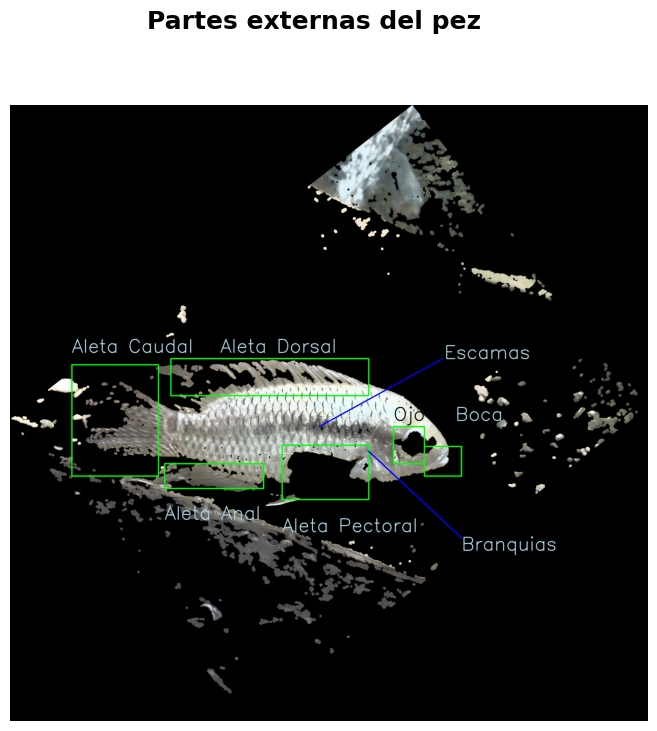


INFORMACION DE LA IMAGEN:

   Dimensiones: (4128, 3096, 3)
   Tipo de datos: uint8
   Rango de valores: [0.000, 212.000]
   Valor promedio de todos los píxeles: 87.886
   Desviación estándar: 33.186


In [149]:
cuadro_texto((500, 2100), (1200, 3000), "Aleta Caudal", (500, 2000), (173, 216, 230), imagen_6)
cuadro_texto((1300, 2050), (2900, 2350), "Aleta Dorsal", (1700, 2000), (173, 216, 230), imagen_6)
cuadro_texto((3100, 2600), (3350, 2900), "Ojo", (3100, 2550), (0, 0, 0), imagen_6)
cuadro_texto((3350, 2760), (3650, 3000), "Boca", (3600, 2550), (173, 216, 230), imagen_6)
cuadro_texto((2200, 2750), (2900, 3190), "Aleta Pectoral", (2200, 3450), (173, 216, 230), imagen_6)
cuadro_texto((1250, 2900), (2050, 3100), "Aleta Anal", (1250, 3350), (173, 216, 230), imagen_6)

linea_texto(imagen_6, (2500, 2600), (3500, 2050), (0, 0, 255), "Escamas", (3510, 2050), (173, 216, 230))
linea_texto(imagen_6, (2900, 2800), (3650, 3500), (0, 0, 255), "Branquias", (3650, 3600), (173, 216, 230))

plt.figure(figsize=(12, 8))
plt.suptitle('Partes externas del pez', fontsize=18, fontweight='bold', y=1.0)
plt.imshow(imagen_6)
plt.axis('off')
plt.show()

mostrar_imagen_info(imagen)

## 9 - Resultado final
Mostramos todos los procesos realizados hasta llegar al resultado funal

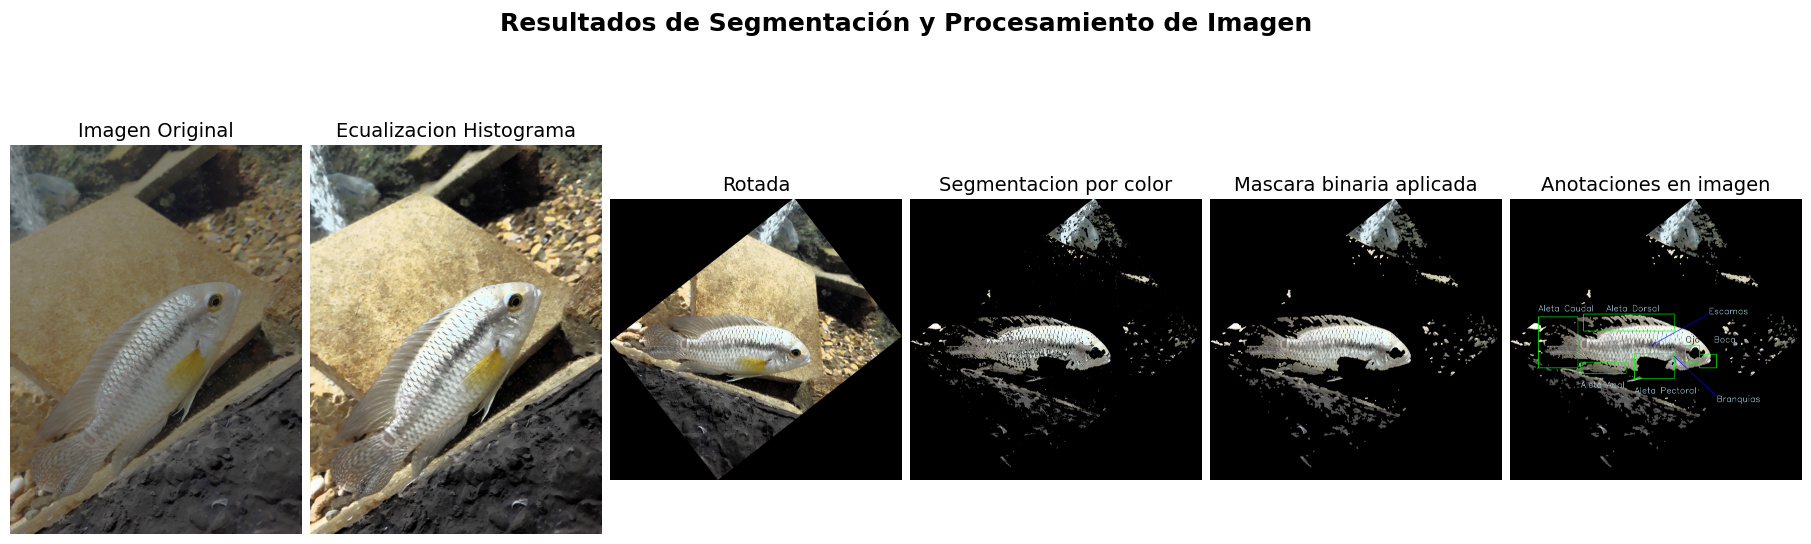

In [144]:
fig, axes = plt.subplots(1, 6, figsize=(18, 6), constrained_layout=True)

imagenes = [imagen_2, imagen_3, imagen_4, imagen_segmentada, imagen_limpia, imagen_6]
titulos = ['Imagen Original', 'Ecualizacion Histograma', 'Rotada', 'Segmentacion por color', 'Mascara binaria aplicada', 'Anotaciones en imagen']

for ax, img, titulo in zip(axes, imagenes, titulos):
    ax.imshow(img)
    ax.set_title(titulo, fontsize=14)
    ax.axis('off')
    ax.set_aspect('equal')  # fuerza el mismo aspecto para todos

fig.suptitle('Resultados de Segmentación y Procesamiento de Imagen', fontsize=18, fontweight='bold', y=1.05)
plt.show()